# Toy BERT
Introduction to problem, motivation etc

insert picture of BERT

### 1(a): Constructing Toy BERT
In this section, we will create a toy example of BERT. The purpose is to familiarize you with the structure of BERT.

From the paper, BERT BASE has $L=12$ layers of transformer blocks, $H = 768$ hidden size and $A = 12$ self-attention heads. For this toy BERT, we will be using $L = 1$, $A = 1$, $H = 4$.

Recall the BERT architecture:
- Transformer blocks
- Feedforward blocks. The feedforward block expands the input from $\mathbb{R}^H$ to $\mathbb{R}^{4H}$ then shrinks it back to $\mathbb{R}^H$ for expressivity and consistency with residual connections.
- Residual connections
- Loss: two objectives, which are token prediction and next sentence prediction. We will simplify the training for toy model.

see diagram

Do comparison on value of H, experiment if we can pass the burden of masking to first layer.

First, we do some imports

In [344]:
import jax
import jax.numpy as jnp
import numpy as np
import functools
import logging
import time
import types
import warnings
import matplotlib.pyplot as plt
from jax import grad, jit, pmap, random
from typing import Optional, Mapping, Any
from sklearn import datasets, manifold # TSNE
from os import listdir
from os.path import isfile, join

try:
    import haiku as hk # Haiku is a neural network library for JAX, developed by DeepMind
    from haiku._src import basic
    from haiku._src import initializers
    from haiku._src import module
except ModuleNotFoundError: # Install haiku if missing
    !pip install --quiet dm-haiku
    import haiku as hk
    from haiku._src import basic
    from haiku._src import initializers
    from haiku._src import module
try:
    import optax # Optax is a gradient processing and optimization library for JAX
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

Next, we define the parameters of our model architecture and training loop.



In [373]:
batch_size = 5  # Train batch size per core
d_model = 4  # model width
num_heads = 1  # Number of attention heads
num_layers = 1  # Number of transformer layers
dropout_rate = 0.1  # Dropout rate

learning_rate = 2e-4  # Max learning-rate
grad_clip_value = 0.25  # Gradient norm clip value

Next, we get our data. Create an empty folder in the directory where this iPython file resides, and upload all the data files into it.

For BERT, the data processing is just as important as the model architecture itself. BERT can take in either a sentence or pairs of sentences. Recall that BERT does the following:

1.   Insert a \<CLS\> token at the start of the input, regardless of whether the input is a sentence or pairs of sentences.
2.   If there are multiple sentences, we separate them by the \<SEP\> token. We always end with a \<SEP\> token as well.
3.   BERT also adds positional encoding (i.e. which index the token is) and sentence encoding (i.e. which sentence does the token belong to).
4.   Since we are training by batches, it may be the case that the sentences in the batches are not of the same length. We append \<BLANK\> tokens.
5.   BERT also masks tokens (in the paper, it is with probability $15\%$). Within this $15\%$, the token is actually masked with probability $80\%$, replaced with a random word $10\%$ and the right one $10\%$.



In [386]:
def getData(batch_size=1, mask=0.15):
  """ 
  batch_size: size of the batch
  mask: the percentage of input replaced with mask, default 15%

  RETURNS
  data_pairs: a list of dictionaries, each element of the form
    {
      "obs": jnp.array,
      "target": jnp.array,
      "ablation": jnp.array
    }
  vocab_size: the total size of vocabulary, including auxiliary tokens
  sequence_length: the maximum length of sequence,
  tracker_ls: human readable list
  """

  direc = './data' # directory
  allfiles = [join(direc, f) for f in listdir(direc) if isfile(join(direc, f))]
  data_pairs = []
  tracker_ls = []

  vocab_map = {"<MASK>": 0, "<CLS>": 1, "<SEP>": 2, "<ISNEXT>": 3, "<NOTNEXT>": 4, "<BLANK>": 5}
  non_word_token = {"<MASK>", "<CLS>", "<SEP>", "<ISNEXT>", "<NOTNEXT>", "<BLANK>"}

  vocab_size = len(vocab_map) # initially, start with <MASK>, <CLS>, <SEP>, <ISNEXT>, <NOTNEXT>, <BLANK>
  max_seq_length = 0

  for file_name in allfiles:
    with open(file_name, 'r') as f:
      lines = f.readlines()
      for line in lines:
        tokens = line.split()
        for token in tokens:
          if token in vocab_map: continue
          vocab_map[token] = vocab_size
          vocab_size += 1
  
  all_obs = []
  all_target = []
  all_human_obs = []
  all_ablation = []
  for file_name in allfiles:
    with open(file_name, 'r') as f:
      lines = f.readlines()
      for i in range(len(lines) - 1):
        follow = 1 if np.random.random() > 0.5 else 0 # whether latter sentence follows former
        if follow:
          tokenized_sentence_1 = lines[i].split()
          tokenized_sentence_2 = lines[i + 1].split()
        else:
          tokenized_sentence_1 = lines[i + 1].split()
          tokenized_sentence_2 = lines[i].split()
        
        label = ["<ISNEXT>"] if follow else ["<NOTNEXT>"]
        
        target = label + tokenized_sentence_1 + ["<SEP>"] + tokenized_sentence_2
        target = [vocab_map[token] for token in target]

        mask_sentence_1 = (np.random.random(len(tokenized_sentence_1)) < mask)
        for j in range(len(mask_sentence_1)):
          if mask_sentence_1[j]: tokenized_sentence_1[j] = "<MASK>"
        mask_sentence_2 = (np.random.random(len(tokenized_sentence_2)) < mask)
        for j in range(len(mask_sentence_2)):
          if mask_sentence_2[j]: tokenized_sentence_2[j] = "<MASK>"
        
        human_obs = ["<CLS>"] + tokenized_sentence_1 + ["<SEP>"] + tokenized_sentence_2
        obs = [vocab_map[token] for token in human_obs]
        ablation = [1 if token in non_word_token else 0 for token in human_obs]
        max_seq_length = max(max_seq_length, len(obs))
        all_obs.append(obs)
        all_target.append(target)
        all_human_obs.append(human_obs)
        all_ablation.append(ablation)
  
  assert len(all_obs) == len(all_target)

  for i in range(0, len(all_obs), batch_size):
    if i + batch_size >= len(all_obs): continue
    obs_batch = []
    target_batch = []
    ablation_batch = []
    human_obs_batch = []
    seq_length = 0
    for j in range(i, i + batch_size):
      seq_length = max(seq_length, len(all_obs[j]))

    for j in range(i, i + batch_size):
      while len(all_obs[j]) < seq_length:
        all_obs[j].append(vocab_map["<BLANK>"])
      obs_batch.append(all_obs[j])
      while len(all_target[j]) < seq_length:
        all_target[j].append(vocab_map["<BLANK>"])
      while len(all_ablation[j]) < seq_length:
        all_ablation[j].append(1)
      target_batch.append(all_target[j])
      human_obs_batch.append(all_human_obs[j])
      ablation_batch.append(all_ablation[j])

    cur_dict = dict()
    cur_dict["obs"] = jnp.array(obs_batch)
    cur_dict["target"] = jnp.array(target_batch)
    cur_dict["ablation"] = jnp.array(ablation_batch)

    tracker_ls.append(human_obs_batch)
    data_pairs.append(cur_dict)
  
  inv_map = dict()
  for key in vocab_map:
    inv_map[vocab_map[key]] = key
  return data_pairs, vocab_size, inv_map, tracker_ls, max_seq_length

In [388]:
# Create the dataset.
train_dataset, vocab_size, inv_map, tracker_dataset, max_seq_length = getData(batch_size=batch_size)
print(max_seq_length)

29


Next, we create the building blocks of the BERT model.

In [389]:
### MultiHeadedAttention class from https://github.com/deepmind/dm-haiku/blob/main/haiku/_src/attention.py
### Adapted for visualization and ablation analysis

class MultiHeadAttention(hk.Module):
  """Multi-headed attention (MHA) module.
  This module is intended for attending over sequences of vectors.
  Rough sketch:
  - Compute keys (K), queries (Q), and values (V) as projections of inputs.
  - Attention weights are computed as W = softmax(QK^T / sqrt(key_size)).
  - Output is another projection of WV^T.
  For more detail, see the original Transformer paper:
    "Attention is all you need" https://arxiv.org/abs/1706.03762.
  Glossary of shapes:
  - T: Sequence length.
  - D: Vector (embedding) size.
  - H: Number of attention heads.
  """

  def __init__(
      self,
      num_heads: int,
      key_size: int,
      # TODO(b/240019186): Remove `w_init_scale`.
      w_init_scale: Optional[float] = None,
      *,
      w_init: Optional[hk.initializers.Initializer] = None,
      value_size: Optional[int] = None,
      model_size: Optional[int] = None,
      name: Optional[str] = None,
  ):
    """Initialises the module.
    Args:
      num_heads: Number of independent attention heads (H).
      key_size: The size of keys (K) and queries used for attention.
      w_init_scale: DEPRECATED. Please use w_init instead.
      w_init: Initialiser for weights in the linear map. Once `w_init_scale` is
        fully deprecated `w_init` will become mandatory. Until then it has a
        default value of `None` for backwards compatability.
      value_size: Optional size of the value projection (V). If None, defaults
        to the key size (K).
      model_size: Optional size of the output embedding (D'). If None, defaults
        to the key size multiplied by the number of heads (K * H).
      name: Optional name for this module.
    """
    super().__init__(name=name)
    self.num_heads = num_heads
    self.key_size = key_size
    self.value_size = value_size or key_size
    self.model_size = model_size or key_size * num_heads

    # Backwards-compatibility for w_init_scale.
    if w_init_scale is not None:
      warnings.warn(
          "w_init_scale is deprecated; please pass an explicit weight "
          "initialiser instead.", DeprecationWarning)
    if w_init and w_init_scale:
      raise ValueError("Please provide only `w_init`, not `w_init_scale`.")
    if w_init is None and w_init_scale is None:
      raise ValueError("Please provide a weight initializer: `w_init`. "
                       "`w_init` will become mandatory once `w_init_scale` is "
                       "fully deprecated.")
    if w_init is None:
      w_init = hk.initializers.VarianceScaling(w_init_scale)
    self.w_init = w_init

  def __call__(
      self,
      query: jnp.ndarray,
      key: jnp.ndarray,
      value: jnp.ndarray,
      mask: Optional[jnp.ndarray] = None,
  ) -> jnp.ndarray:
    """Computes (optionally masked) MHA with queries, keys & values.
    This module broadcasts over zero or more 'batch-like' leading dimensions.
    Args:
      query: Embeddings sequence used to compute queries; shape [..., T', D_q].
      key: Embeddings sequence used to compute keys; shape [..., T, D_k].
      value: Embeddings sequence used to compute values; shape [..., T, D_v].
      mask: Optional mask applied to attention weights; shape [..., H=1, T', T].
    Returns:
      A new sequence of embeddings, consisting of a projection of the
        attention-weighted value projections; shape [..., T', D'].
    """

    # In shape hints below, we suppress the leading dims [...] for brevity.
    # Hence e.g. [A, B] should be read in every case as [..., A, B].
    *leading_dims, sequence_length, _ = query.shape
    projection = self._linear_projection

    # Compute key/query/values (overload K/Q/V to denote the respective sizes).
    query_heads = projection(query, self.key_size, "query")  # [T', H, Q=K]
    key_heads = projection(key, self.key_size, "key")  # [T, H, K]
    value_heads = projection(value, self.value_size, "value")  # [T, H, V]

    # Compute attention weights.
    attn_logits = jnp.einsum("...thd,...Thd->...htT", query_heads, key_heads)
    attn_logits = attn_logits / np.sqrt(self.key_size).astype(key.dtype)
    if mask is not None:
      if mask.ndim != attn_logits.ndim:
        raise ValueError(
            f"Mask dimensionality {mask.ndim} must match logits dimensionality "
            f"{attn_logits.ndim}."
        )
      attn_logits = jnp.where(mask, attn_logits, -1e30)
    attn_weights = jax.nn.softmax(attn_logits)  # [H, T', T], propagate this attention weight for visualization

    # Weight the values by the attention and flatten the head vectors.
    attn = jnp.einsum("...htT,...Thd->...thd", attn_weights, value_heads)
    attn = jnp.reshape(attn, (*leading_dims, sequence_length, -1))  # [T', H*V]

    # Apply another projection to get the final embeddings.
    final_projection = hk.Linear(self.model_size, w_init=self.w_init)
    return final_projection(attn), attn_weights  # [T', D'], propagate attention weight for visualization

  @hk.transparent
  def _linear_projection(
      self,
      x: jnp.ndarray,
      head_size: int,
      name: Optional[str] = None,
  ) -> jnp.ndarray:
    y = hk.Linear(self.num_heads * head_size, w_init=self.w_init, name=name)(x)
    *leading_dims, _ = x.shape
    return y.reshape((*leading_dims, self.num_heads, head_size))

In [390]:
class SelfAttention(MultiHeadAttention):
    """Self attention with a causal mask applied."""
    def __call__(
            self,
            query: jnp.ndarray,
            key: Optional[jnp.ndarray] = None,
            value: Optional[jnp.ndarray] = None,
            mask: Optional[jnp.ndarray] = None,
    ) -> jnp.ndarray:
        key = key if key is not None else query
        value = value if value is not None else query

        seq_len = query.shape[1]
        ### if you add this, you are masking the future
        #causal_mask = np.tril(np.ones((seq_len, seq_len)))
        #mask = mask * causal_mask if mask is not None else causal_mask

        return super().__call__(query, key, value, None)

class DenseBlock(hk.Module):
    """A 2-layer MLP"""
    def __init__(self,
                 init_scale: float,
                 widening_factor: int = 4,
                 name: Optional[str] = None):
        super().__init__(name=name)
        self._init_scale = init_scale
        self._widening_factor = widening_factor

    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        hiddens = x.shape[-1]
        initializer = hk.initializers.VarianceScaling(self._init_scale)
        x = hk.Linear(self._widening_factor * hiddens, w_init=initializer)(x)
        x = jax.nn.gelu(x)
        return hk.Linear(hiddens, w_init=initializer)(x)

def layer_norm(x: jnp.ndarray, name: Optional[str] = None) -> jnp.ndarray:
    """Apply a unique LayerNorm to x with default settings."""
    return hk.LayerNorm(axis=-1,
                        create_scale=True,
                        create_offset=True,
                        name=name)(x)

class Transformer(hk.Module):
    """A transformer stack."""
    def __init__(self,
                 num_heads: int,
                 num_layers: int,
                 dropout_rate: float,
                 name: Optional[str] = None):
        super().__init__(name=name)
        self._num_layers = num_layers
        self._num_heads = num_heads
        self._dropout_rate = dropout_rate
    
    def __call__(self,
                 h: jnp.ndarray,
                 mask: Optional[jnp.ndarray],
                 is_training: bool) -> jnp.ndarray:
        """Connects the transformer.
        Args:
          h: Inputs, [B, T, H].
          mask: Padding mask, [B, T].
          is_training: Whether we're training or not.
        Returns:
          Array of shape [B, T, H].
        """
        init_scale = 2. / self._num_layers
        dropout_rate = self._dropout_rate if is_training else 0.
        tracker = []
        if mask is not None:
            mask = mask[:, None, None, :]
        for i in range(self._num_layers):
            h_norm = layer_norm(h, name=f'h{i}_ln_1')
            h_attn, attn_matrix = SelfAttention(
                num_heads=self._num_heads,
                key_size=d_model//self._num_heads,
                w_init_scale=init_scale,
                name=f'h{i}_attn')(h_norm, mask=mask)
            tracker.append(attn_matrix)
            h_attn = hk.dropout(hk.next_rng_key(), dropout_rate, h_attn)
            h = h + h_attn
            h_norm = layer_norm(h, name=f'h{i}_ln_2')
            h_dense = DenseBlock(init_scale, name=f'h{i}_mlp')(h_norm)
            h_dense = hk.dropout(hk.next_rng_key(), dropout_rate, h_dense)
            h = h + h_dense
        h = layer_norm(h, name='ln_f')
        return h, tracker

def embeddings(data: Mapping[str, jnp.ndarray], vocab_size: int) :
    print("embeddings")
    tokens = data['obs']
    input_mask = jnp.greater(tokens, -100000)
    print("input mask", input_mask)
    seq_length = tokens.shape[1]
    # Embed the input tokens and positions.
    embed_init = hk.initializers.TruncatedNormal(stddev=0.02)
    token_embedding_map = hk.Embed(vocab_size, d_model, w_init=embed_init)
    token_embs = token_embedding_map(tokens)
    print("seq_length", seq_length)
    positional_embeddings = hk.get_parameter(
        'pos_embs', [100, d_model], init=embed_init)
    input_embeddings = token_embs + positional_embeddings[:seq_length]
    return input_embeddings, input_mask

We now define the forward and the loss function.

In [391]:
def build_forward_fn(vocab_size: int, d_model: int, num_heads: int,
                     num_layers: int, dropout_rate: float):
    """Create the model's forward pass."""

    def forward_fn(data: Mapping[str, jnp.ndarray],
                   is_training: bool = True) -> jnp.ndarray:
        """Forward pass."""
        input_embeddings, input_mask = embeddings(data, vocab_size)

        # Run the transformer over the inputs.
        transformer = Transformer(
            num_heads=num_heads, num_layers=num_layers, dropout_rate=dropout_rate)
        output_embeddings, tracker = transformer(input_embeddings, input_mask, is_training)

        # Reverse the embeddings (untied).
        return hk.Linear(vocab_size)(output_embeddings), tracker

    return forward_fn

def lm_loss_fn(forward_fn,
               vocab_size: int,
               params,
               rng,
               data: Mapping[str, jnp.ndarray],
               is_training: bool = True) -> jnp.ndarray:
    """Compute the loss on data wrt params."""
    logits, _ = forward_fn(params, rng, data, is_training)
    targets = jax.nn.one_hot(data['target'], vocab_size)
    assert logits.shape == targets.shape

    mask = jnp.greater(data['obs'], 0)
    loss = -jnp.sum(targets * jax.nn.log_softmax(logits), axis=-1)
    loss = jnp.sum(loss * mask) / jnp.sum(mask)

    return loss
  
def lm_tracker_fn(forward_fn,
               params,
               rng,
               data: Mapping[str, jnp.ndarray],
               is_training: bool = True) -> jnp.ndarray:
    """Compute the loss on data wrt params."""
    _, tracker = forward_fn(params, rng, data, is_training)
    return tracker

In [392]:
class GradientUpdater:
    """A stateless abstraction around an init_fn/update_fn pair.
    This extracts some common boilerplate from the training loop.
    """

    def __init__(self, net_init, loss_fn, tracker_fn, optimizer: optax.GradientTransformation):
        self._net_init = net_init
        self._loss_fn = loss_fn
        self._tracker_fn = tracker_fn
        self._opt = optimizer

    @functools.partial(jax.jit, static_argnums=0)
    def init(self, master_rng, data):
        """Initializes state of the updater."""
        out_rng, init_rng = jax.random.split(master_rng)
        params = self._net_init(init_rng, data)
        opt_state = self._opt.init(params)
        out = dict(
            step=np.array(0),
            rng=out_rng,
            opt_state=opt_state,
            params=params,
        )
        return out

    @functools.partial(jax.jit, static_argnums=0)
    def update(self, state: Mapping[str, Any], data: Mapping[str, jnp.ndarray]):
        """Updates the state using some data and returns metrics."""
        rng, new_rng = jax.random.split(state['rng'])
        params = state['params']
        loss, g = jax.value_and_grad(self._loss_fn)(params, rng, data)

        updates, opt_state = self._opt.update(g, state['opt_state'])
        params = optax.apply_updates(params, updates)

        new_state = {
            'step': state['step'] + 1,
            'rng': new_rng,
            'opt_state': opt_state,
            'params': params,
        }

        metrics = {
            'step': state['step'],
            'loss': loss,
        }
        return new_state, metrics

    @functools.partial(jax.jit, static_argnums=0)
    def track(self, state: Mapping[str, Any], data: Mapping[str, jnp.ndarray]):
        """Updates the state using some data and returns metrics."""
        rng, new_rng = jax.random.split(state['rng'])
        params = state['params']
        return self._tracker_fn(params, rng, data)

We now run the training loop.

In [393]:
# Set up the model, loss, and updater.
forward_fn = build_forward_fn(vocab_size, d_model, num_heads, num_layers, dropout_rate)
forward_fn = hk.transform(forward_fn)
loss_fn = functools.partial(lm_loss_fn, forward_fn.apply, vocab_size)
tracker_fn = functools.partial(lm_tracker_fn, forward_fn.apply)

optimizer = optax.chain(
    optax.clip_by_global_norm(grad_clip_value),
    optax.adam(learning_rate, b1=0.9, b2=0.99))

updater = GradientUpdater(forward_fn.init, loss_fn, tracker_fn, optimizer)

# Initialize parameters.
print('Initializing parameters...')
rng = jax.random.PRNGKey(428)
data = train_dataset[0]
state = updater.init(rng, data)

print('Starting train loop...')
prev_time = time.time()

loss_graph = []

for i in range(1, len(train_dataset)):
  print("train_dataset {}".format(i))
  data = train_dataset[i]
  state, metrics = updater.update(state, data)
  loss_graph.append(float(np.array(metrics['loss'])))

Initializing parameters...
embeddings
input mask Traced<ShapedArray(bool[5,10])>with<DynamicJaxprTrace(level=0/1)>
seq_length 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: DeprecationWarning: w_init_scale is deprecated; please pass an explicit weight initialiser instead.


Starting train loop...
train_dataset 1
embeddings
input mask Traced<ShapedArray(bool[5,13])>with<DynamicJaxprTrace(level=0/1)>
seq_length 13
train_dataset 2
embeddings
input mask Traced<ShapedArray(bool[5,12])>with<DynamicJaxprTrace(level=0/1)>
seq_length 12
train_dataset 3
train_dataset 4
train_dataset 5
train_dataset 6
embeddings
input mask Traced<ShapedArray(bool[5,11])>with<DynamicJaxprTrace(level=0/1)>
seq_length 11
train_dataset 7
embeddings
input mask Traced<ShapedArray(bool[5,15])>with<DynamicJaxprTrace(level=0/1)>
seq_length 15
train_dataset 8
train_dataset 9
train_dataset 10
train_dataset 11
embeddings
input mask Traced<ShapedArray(bool[5,10])>with<DynamicJaxprTrace(level=0/1)>
seq_length 10
train_dataset 12
train_dataset 13
train_dataset 14
train_dataset 15
train_dataset 16
embeddings
input mask Traced<ShapedArray(bool[5,17])>with<DynamicJaxprTrace(level=0/1)>
seq_length 17
train_dataset 17
embeddings
input mask Traced<ShapedArray(bool[5,20])>with<DynamicJaxprTrace(level=0/1

Notice how the dataset is trained very quickly for the later few batches? I suppose it is because of JAX's magical ability. (Insert reason why...)

We can now visualize the training loss.

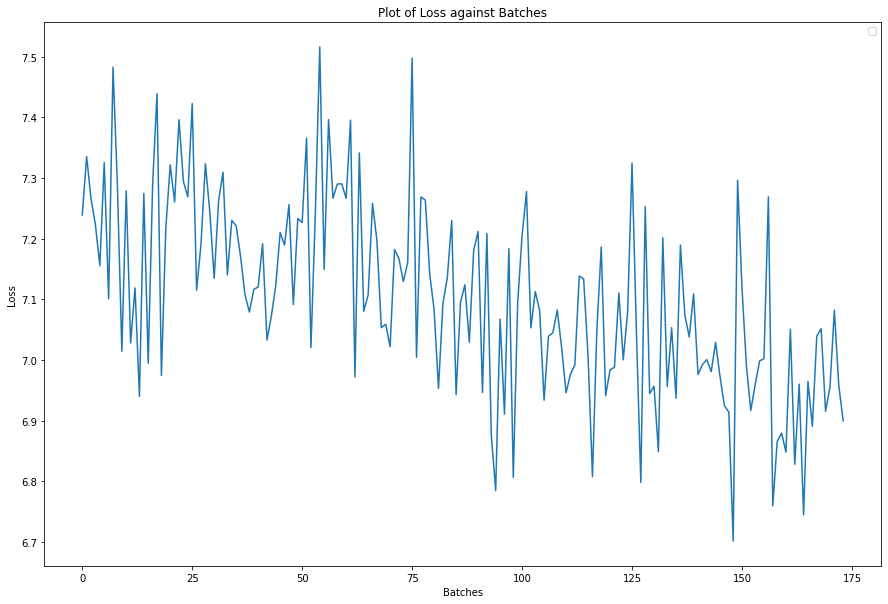

In [394]:
# Visualize training loss
plt.figure(figsize=(15,10))
plt.plot(np.arange(len(loss_graph)), loss_graph)
plt.xlabel('Batches') 
plt.ylabel('Loss')
plt.legend()
plt.title('Plot of Loss against Batches')
plt.show()

We can also visualize how the different words/tokens are embedded by the embedding layer, i.e. what did the embedding layer learn without context?

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


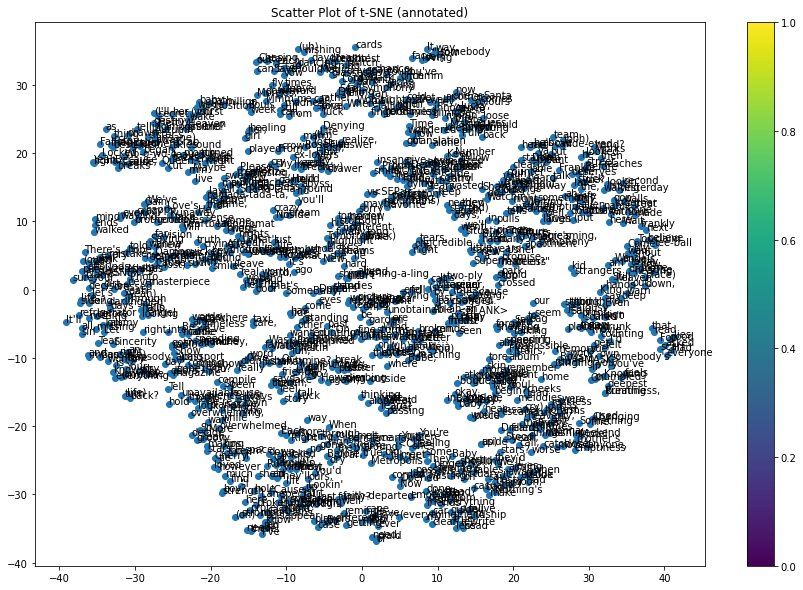

In [395]:
# TSNE on embedding layer
embedding_numpy = np.array(state["params"]["embed"]["embeddings"])
tsne = manifold.TSNE(n_components=2, random_state=42)
embedding_numpy = tsne.fit_transform(embedding_numpy)

plt.figure(figsize=(15,10))
plt.scatter(embedding_numpy[:,0], embedding_numpy[:,1], cmap='viridis')
for i in range(len(embedding_numpy)):
  plt.annotate(inv_map[i], (embedding_numpy[i][0], embedding_numpy[i][1]))
plt.colorbar()
plt.title("Scatter Plot of t-SNE (annotated)")
plt.show()

### 1(b): Visualizing Attention Plots
Visualizing the attention plots

In [396]:
attention_scores = updater.track(state, train_dataset[0])
assert attention_scores[0][0][0].shape[0] == attention_scores[0][0][0].shape[1] # check that it is a square

embeddings
input mask Traced<ShapedArray(bool[5,10])>with<DynamicJaxprTrace(level=0/1)>
seq_length 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: DeprecationWarning: w_init_scale is deprecated; please pass an explicit weight initialiser instead.


In [397]:
" ".join(tracker_dataset[0][0])

"<CLS> She's watching the taxi <MASK> <SEP> He pulls away"

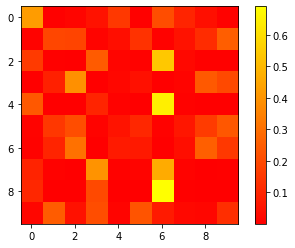

In [398]:
plt.imshow(attention_scores[0][2][0], cmap='autumn')
plt.colorbar()
plt.show()

We can see the effects of the masked language attention model here. (Actually why does this masked plot resemble GPT? Some implementation error somewhere?) We see high attention on unmasked words (meaning that the attention block is indeed using contextual information).

In [12]:
state.keys()

dict_keys(['opt_state', 'params', 'rng', 'step'])

In [14]:
state['params'].keys()

dict_keys(['embed', 'linear', 'transformer/h0_attn/key', 'transformer/h0_attn/linear', 'transformer/h0_attn/query', 'transformer/h0_attn/value', 'transformer/h0_ln_1', 'transformer/h0_ln_2', 'transformer/h0_mlp/linear', 'transformer/h0_mlp/linear_1', 'transformer/ln_f', '~'])

In [17]:
state['params']['transformer/h0_attn/key']

{'b': DeviceArray([-4.7865128e-06,  1.0598570e-06,  3.4272222e-07,
              -3.4626137e-06], dtype=float32),
 'w': DeviceArray([[ 0.42377868,  0.75873053,  0.3375257 , -0.07509849],
              [ 0.21688682, -0.7953275 , -0.37617567, -1.132926  ],
              [ 0.1953972 , -0.24128394, -0.43016842,  0.04279345],
              [-0.696217  , -0.35004464, -0.85770833, -0.20464377]],            dtype=float32)}

### 1(c): Ablation Analysis
There are a few ways which we can perform ablation analysis. We will experiment with two here:

1.   Removal of NSP task (so no sentence level context) (This is done in the original BERT paper)
2.   k-most important (we note that a lot of attention is wasted on \<CLS\> and \<SEP\> tokens, which doesn't necessarily contain information on words.) So we restrict attention to those tokens.



In [404]:
class MultiHeadAttentionAblation(hk.Module):
  """Multi-headed attention (MHA) module.
  This module is intended for attending over sequences of vectors.
  Rough sketch:
  - Compute keys (K), queries (Q), and values (V) as projections of inputs.
  - Attention weights are computed as W = softmax(QK^T / sqrt(key_size)).
  - Output is another projection of WV^T.
  For more detail, see the original Transformer paper:
    "Attention is all you need" https://arxiv.org/abs/1706.03762.
  Glossary of shapes:
  - T: Sequence length.
  - D: Vector (embedding) size.
  - H: Number of attention heads.
  """

  def __init__(
      self,
      num_heads: int,
      key_size: int,
      # TODO(b/240019186): Remove `w_init_scale`.
      w_init_scale: Optional[float] = None,
      *,
      w_init: Optional[hk.initializers.Initializer] = None,
      value_size: Optional[int] = None,
      model_size: Optional[int] = None,
      name: Optional[str] = None
  ):
    """Initialises the module.
    Args:
      num_heads: Number of independent attention heads (H).
      key_size: The size of keys (K) and queries used for attention.
      w_init_scale: DEPRECATED. Please use w_init instead.
      w_init: Initialiser for weights in the linear map. Once `w_init_scale` is
        fully deprecated `w_init` will become mandatory. Until then it has a
        default value of `None` for backwards compatability.
      value_size: Optional size of the value projection (V). If None, defaults
        to the key size (K).
      model_size: Optional size of the output embedding (D'). If None, defaults
        to the key size multiplied by the number of heads (K * H).
      name: Optional name for this module.
    """
    super().__init__(name=name)
    self.num_heads = num_heads
    self.key_size = key_size
    self.value_size = value_size or key_size
    self.model_size = model_size or key_size * num_heads

    # Backwards-compatibility for w_init_scale.
    if w_init_scale is not None:
      warnings.warn(
          "w_init_scale is deprecated; please pass an explicit weight "
          "initialiser instead.", DeprecationWarning)
    if w_init and w_init_scale:
      raise ValueError("Please provide only `w_init`, not `w_init_scale`.")
    if w_init is None and w_init_scale is None:
      raise ValueError("Please provide a weight initializer: `w_init`. "
                       "`w_init` will become mandatory once `w_init_scale` is "
                       "fully deprecated.")
    if w_init is None:
      w_init = hk.initializers.VarianceScaling(w_init_scale)
    self.w_init = w_init

  def __call__(
      self,
      query: jnp.ndarray,
      key: jnp.ndarray,
      value: jnp.ndarray,
      mask: Optional[jnp.ndarray] = None,
      ablation_ls: Optional[jnp.ndarray] = None
  ) -> jnp.ndarray:
    """Computes (optionally masked) MHA with queries, keys & values.
    This module broadcasts over zero or more 'batch-like' leading dimensions.
    Args:
      query: Embeddings sequence used to compute queries; shape [..., T', D_q].
      key: Embeddings sequence used to compute keys; shape [..., T, D_k].
      value: Embeddings sequence used to compute values; shape [..., T, D_v].
      mask: Optional mask applied to attention weights; shape [..., H=1, T', T].
    Returns:
      A new sequence of embeddings, consisting of a projection of the
        attention-weighted value projections; shape [..., T', D'].
    """

    # In shape hints below, we suppress the leading dims [...] for brevity.
    # Hence e.g. [A, B] should be read in every case as [..., A, B].
    *leading_dims, sequence_length, _ = query.shape
    projection = self._linear_projection

    # Compute key/query/values (overload K/Q/V to denote the respective sizes).
    query_heads = projection(query, self.key_size, "query")  # [T', H, Q=K]
    key_heads = projection(key, self.key_size, "key")  # [T, H, K]
    value_heads = projection(value, self.value_size, "value")  # [T, H, V]

    # Compute attention weights.
    attn_logits = jnp.einsum("...thd,...Thd->...htT", query_heads, key_heads)
    attn_logits = attn_logits / np.sqrt(self.key_size).astype(key.dtype)

    if mask is not None:
      if mask.ndim != attn_logits.ndim:
        raise ValueError(
            f"Mask dimensionality {mask.ndim} must match logits dimensionality "
            f"{attn_logits.ndim}."
        )
      attn_logits = jnp.where(mask, attn_logits, -1e30)

    ### ABLATION PART
    ### NEED TO READJUST THE LOGITS OF THOSE ATTENTION IN THE ABLATION_LS
    #### TODO!!!
    ####
    if ablation_ls is not None:
      if ablation_ls.ndim != attn_logits.ndim:
        raise ValueError(
            f"Ablation Mask dimensionality {ablation_ls.ndim} must match logits dimensionality "
            f"{attn_logits.ndim}."
        )
      attn_logits = jnp.where(ablation_ls, 1e-30, attn_logits)
      #attn_logits = jnp.where(ablation_ls, attn_logits, attn_logits/2.) # change this to max(attn_logits, broadcasted)

    attn_weights = jax.nn.softmax(attn_logits)  # [H, T', T]
    ### END OF ABLATION PART

    # Weight the values by the attention and flatten the head vectors.
    attn = jnp.einsum("...htT,...Thd->...thd", attn_weights, value_heads)
    attn = jnp.reshape(attn, (*leading_dims, sequence_length, -1))  # [T', H*V]

    # Apply another projection to get the final embeddings.
    final_projection = hk.Linear(self.model_size, w_init=self.w_init)
    return final_projection(attn), attn_weights  # [T', D']

  @hk.transparent
  def _linear_projection(
      self,
      x: jnp.ndarray,
      head_size: int,
      name: Optional[str] = None,
  ) -> jnp.ndarray:
    y = hk.Linear(self.num_heads * head_size, w_init=self.w_init, name=name)(x)
    *leading_dims, _ = x.shape
    return y.reshape((*leading_dims, self.num_heads, head_size))

In [405]:
class SelfAttentionAblation(MultiHeadAttentionAblation):
    """Self attention with a causal mask applied."""
    def __call__(
            self,
            query: jnp.ndarray,
            key: Optional[jnp.ndarray] = None,
            value: Optional[jnp.ndarray] = None,
            mask: Optional[jnp.ndarray] = None,
            ablation_ls: Optional[jnp.ndarray] = None
    ) -> jnp.ndarray:
        key = key if key is not None else query
        value = value if value is not None else query

        seq_len = query.shape[1]
        ### if you add this, you are masking the future
        #causal_mask = np.tril(np.ones((seq_len, seq_len)))
        #mask = mask * causal_mask if mask is not None else causal_mask

        return super().__call__(query, key, value, mask=None, ablation_ls=ablation_ls)

In [406]:
class TransformerAblation(hk.Module):
    """An ablation transformer stack."""
    def __init__(self,
                 num_heads: int,
                 num_layers: int,
                 dropout_rate: float,
                 name: Optional[str] = None):
        super().__init__(name=name)
        self._num_layers = num_layers
        self._num_heads = num_heads
        self._dropout_rate = dropout_rate
    
    def __call__(self,
                 h: jnp.ndarray,
                 mask: Optional[jnp.ndarray],
                 ablation_ls: Optional[jnp.ndarray],
                 is_training: bool) -> jnp.ndarray:
        """Connects the transformer.
        Args:
          h: Inputs, [B, T, H].
          mask: Padding mask, [B, T].
          is_training: Whether we're training or not.
        Returns:
          Array of shape [B, T, H].
        """
        init_scale = 2. / self._num_layers
        dropout_rate = self._dropout_rate if is_training else 0.
        tracker = []
        if mask is not None:
            mask = mask[:, None, None, :]
        if ablation_ls is not None:
            ablation_ls = ablation_ls[:, None, None, :]
        for i in range(self._num_layers):
            h_norm = layer_norm(h, name=f'h{i}_ln_1')
            h_attn, attn_matrix = SelfAttentionAblation(
                num_heads=self._num_heads,
                key_size=d_model//self._num_heads,
                w_init_scale=init_scale,
                name=f'h{i}_attn')(h_norm, mask=mask, ablation_ls=ablation_ls) # attached ablation_ls here
            tracker.append(attn_matrix)
            h_attn = hk.dropout(hk.next_rng_key(), dropout_rate, h_attn)
            h = h + h_attn
            h_norm = layer_norm(h, name=f'h{i}_ln_2')
            h_dense = DenseBlock(init_scale, name=f'h{i}_mlp')(h_norm)
            h_dense = hk.dropout(hk.next_rng_key(), dropout_rate, h_dense)
            h = h + h_dense
        h = layer_norm(h, name='ln_f')
        return h, tracker

In [410]:
def build_ablation_forward_fn(vocab_size: int, d_model: int, num_heads: int,
                     num_layers: int, dropout_rate: float):
    """Create the model's forward pass."""

    def forward_fn(data: Mapping[str, jnp.ndarray],
                   is_training: bool = True) -> jnp.ndarray:
        """Forward pass."""
        input_embeddings, input_mask = embeddings(data, vocab_size)

        # Run the transformer over the inputs.
        transformer = TransformerAblation(
            num_heads=num_heads, num_layers=num_layers, dropout_rate=dropout_rate)
        output_embeddings, tracker = transformer(input_embeddings, input_mask, data["ablation"], is_training)

        # Reverse the embeddings (untied).
        return hk.Linear(vocab_size)(output_embeddings), tracker

    return forward_fn

def ablation_loss_fn(forward_fn,
               vocab_size: int,
               params,
               rng,
               data: Mapping[str, jnp.ndarray],
               is_training: bool = True) -> jnp.ndarray:
    """Compute the loss on data wrt params."""
    logits, _ = forward_fn(params, rng, data, is_training)
    targets = jax.nn.one_hot(data['target'], vocab_size)
    assert logits.shape == targets.shape

    mask = jnp.greater(data['obs'], 0)
    loss = -jnp.sum(targets * jax.nn.log_softmax(logits), axis=-1)
    loss = jnp.sum(loss * mask) / jnp.sum(mask)
    return loss

def ablation_tracker_fn(forward_fn,
               params,
               rng,
               data: Mapping[str, jnp.ndarray],
               is_training: bool = True) -> jnp.ndarray:
    """Compute the loss on data wrt params."""
    _, tracker = forward_fn(params, rng, data, is_training)
    return tracker

In [411]:
# Set up the model, loss, and updater.
ablation_forward_fn = build_ablation_forward_fn(vocab_size, d_model, num_heads, num_layers, dropout_rate)
ablation_forward_fn = hk.transform(ablation_forward_fn)
ablation_loss_fn = functools.partial(ablation_loss_fn, ablation_forward_fn.apply, vocab_size)
ablation_tracker_fn = functools.partial(ablation_tracker_fn, ablation_forward_fn.apply)

optimizer = optax.chain(
    optax.clip_by_global_norm(grad_clip_value),
    optax.adam(learning_rate, b1=0.9, b2=0.99))

updater = GradientUpdater(ablation_forward_fn.init, ablation_loss_fn, ablation_tracker_fn, optimizer)

# Initialize parameters.
print('Initializing parameters...')
rng = jax.random.PRNGKey(428)
data = train_dataset[0]
print(train_dataset[0])
state = updater.init(rng, data)

print('Starting train loop...')
prev_time = time.time()

ablation_loss_graph = []

for i in range(1, len(train_dataset)):
  print("train_dataset {}".format(i))
  data = train_dataset[i]
  state, metrics = updater.update(state, data)
  ablation_loss_graph.append(float(np.array(metrics['loss'])))

Initializing parameters...
{'obs': DeviceArray([[ 1,  6,  7,  8,  9,  0,  2, 11, 12, 13],
             [ 1, 11, 12, 13,  2,  6, 14,  5,  5,  5],
             [ 1,  6,  0,  2, 15, 16, 17, 18,  0,  5],
             [ 1,  0, 21, 22,  2, 15, 16, 17, 18, 19],
             [ 1, 23, 24,  2, 20, 21, 22,  5,  5,  5]], dtype=int32), 'target': DeviceArray([[ 3,  6,  7,  8,  9, 10,  2, 11, 12, 13],
             [ 3, 11, 12, 13,  2,  6, 14,  5,  5,  5],
             [ 3,  6, 14,  2, 15, 16, 17, 18, 19,  5],
             [ 4, 20, 21, 22,  2, 15, 16, 17, 18, 19],
             [ 4, 23, 24,  2, 20, 21, 22,  5,  5,  5]], dtype=int32), 'ablation': DeviceArray([[1, 0, 0, 0, 0, 1, 1, 0, 0, 0],
             [1, 0, 0, 0, 1, 0, 0, 1, 1, 1],
             [1, 0, 1, 1, 0, 0, 0, 0, 1, 1],
             [1, 1, 0, 0, 1, 0, 0, 0, 0, 0],
             [1, 0, 0, 1, 0, 0, 0, 1, 1, 1]], dtype=int32)}
embeddings
input mask Traced<ShapedArray(bool[5,10])>with<DynamicJaxprTrace(level=0/1)>
seq_length 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: w_init_scale is deprecated; please pass an explicit weight initialiser instead.


Starting train loop...
train_dataset 1
embeddings
input mask Traced<ShapedArray(bool[5,13])>with<DynamicJaxprTrace(level=0/1)>
seq_length 13
train_dataset 2
embeddings
input mask Traced<ShapedArray(bool[5,12])>with<DynamicJaxprTrace(level=0/1)>
seq_length 12
train_dataset 3
train_dataset 4
train_dataset 5
train_dataset 6
embeddings
input mask Traced<ShapedArray(bool[5,11])>with<DynamicJaxprTrace(level=0/1)>
seq_length 11
train_dataset 7
embeddings
input mask Traced<ShapedArray(bool[5,15])>with<DynamicJaxprTrace(level=0/1)>
seq_length 15
train_dataset 8
train_dataset 9
train_dataset 10
train_dataset 11
embeddings
input mask Traced<ShapedArray(bool[5,10])>with<DynamicJaxprTrace(level=0/1)>
seq_length 10
train_dataset 12
train_dataset 13
train_dataset 14
train_dataset 15
train_dataset 16
embeddings
input mask Traced<ShapedArray(bool[5,17])>with<DynamicJaxprTrace(level=0/1)>
seq_length 17
train_dataset 17
embeddings
input mask Traced<ShapedArray(bool[5,20])>with<DynamicJaxprTrace(level=0/1

In [412]:
ablation_attention_scores = updater.track(state, train_dataset[0])
assert ablation_attention_scores[0][0][0].shape[0] == ablation_attention_scores[0][0][0].shape[1] # check that it is a square

embeddings
input mask Traced<ShapedArray(bool[5,10])>with<DynamicJaxprTrace(level=0/1)>
seq_length 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: w_init_scale is deprecated; please pass an explicit weight initialiser instead.


In [421]:
" ".join(tracker_dataset[0][0])

"<CLS> She's watching the taxi <MASK> <SEP> He pulls away"

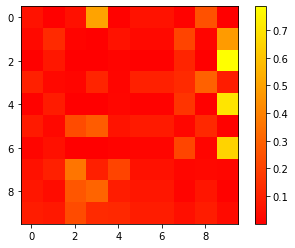

In [422]:
plt.imshow(ablation_attention_scores[0][0][0], cmap='autumn')
plt.colorbar()
plt.show()

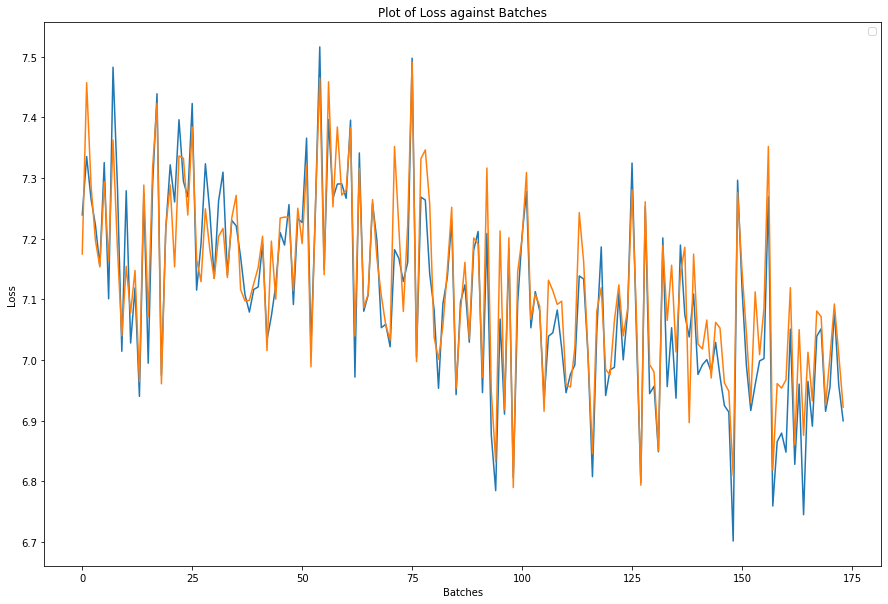

In [423]:
# Visualize training loss
plt.figure(figsize=(15,10))
plt.plot(np.arange(len(loss_graph)), loss_graph)
plt.plot(np.arange(len(ablation_loss_graph)), ablation_loss_graph)
plt.xlabel('Batches') 
plt.ylabel('Loss')
plt.legend()
plt.title('Plot of Loss against Batches')
plt.show()

### 1(d): Applying Pre-training on a Downstream Task
The whole spirit of pre-training is to use it for downstream task. For this part, we will do a task that we are familiar with. Multiple choice. We will have a prompt, followed by a few options. We will choose the one that best matches the prompt.

For this, we will use the output corresponding to the \<CLS\> token, because that contains sentence level context.

In [364]:
def build_multiple_choice_forward_fn(vocab_size: int, d_model: int, num_heads: int,
                     num_layers: int, dropout_rate: float):
    """Create the model's forward pass."""

    def multiple_choice_forward_fn(data: Mapping[str, jnp.ndarray],
                   is_training: bool = True) -> jnp.ndarray:
        """Forward pass."""
        input_embeddings, input_mask = embeddings(data, vocab_size)

        # Run the transformer over the inputs.
        transformer = Transformer(
            num_heads=num_heads, num_layers=num_layers, dropout_rate=dropout_rate)
        output_embeddings, _ = transformer(input_embeddings, input_mask, is_training)


        # Reverse the embeddings (untied).
        return hk.Linear(vocab_size)(output_embeddings)

    return multiple_choice_forward_fn

def multiple_choice_loss_fn(forward_fn,
               vocab_size: int,
               params,
               rng,
               data: Mapping[str, jnp.ndarray],
               is_training: bool = True) -> jnp.ndarray:
    """Compute the loss on data wrt params."""
    logits = forward_fn(params, rng, data, is_training)
    targets = jax.nn.one_hot(data['target'], vocab_size)
    assert logits.shape == targets.shape

    #### TODO NEED TO EDIT THE LOSS HERE

    mask = jnp.greater(data['obs'], 0)
    loss = -jnp.sum(targets * jax.nn.log_softmax(logits), axis=-1)
    loss = jnp.sum(loss * mask) / jnp.sum(mask)

    return loss

In [365]:
# Set up the model, loss, and updater.
multiple_choice_forward_fn = build_multiple_choice_forward_fn(vocab_size, d_model, num_heads, num_layers, dropout_rate)
multiple_choice_forward_fn = hk.transform(multiple_choice_forward_fn)
mc_loss_fn = functools.partial(multiple_choice_loss_fn, multiple_choice_forward_fn.apply, vocab_size)

optimizer = optax.chain(
    optax.clip_by_global_norm(grad_clip_value),
    optax.adam(learning_rate, b1=0.9, b2=0.99))

updater = GradientUpdater(multiple_choice_forward_fn.init, mc_loss_fn, None, optimizer)

# Initialize parameters.
print('Initializing parameters...')
rng = jax.random.PRNGKey(428)
data = train_dataset[0]
state = updater.init(rng, data)

print('Starting train loop...')
prev_time = time.time()

loss_graph = []

for i in range(1, len(train_dataset)):
  print("train_dataset {}".format(i))
  data = train_dataset[i]
  state, metrics = updater.update(state, data)
  loss_graph.append(float(np.array(metrics['loss'])))

Initializing parameters...
Traced<ShapedArray(bool[5,29])>with<DynamicJaxprTrace(level=0/1)>
29


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: DeprecationWarning: w_init_scale is deprecated; please pass an explicit weight initialiser instead.


Starting train loop...
train_dataset 1
Traced<ShapedArray(bool[5,29])>with<DynamicJaxprTrace(level=0/1)>
29
train_dataset 2
train_dataset 3
train_dataset 4
train_dataset 5
train_dataset 6
train_dataset 7
train_dataset 8
train_dataset 9
train_dataset 10
train_dataset 11
train_dataset 12
train_dataset 13
train_dataset 14
train_dataset 15
train_dataset 16
train_dataset 17
train_dataset 18
train_dataset 19
train_dataset 20
train_dataset 21
train_dataset 22
train_dataset 23
train_dataset 24
train_dataset 25
train_dataset 26
train_dataset 27
train_dataset 28
train_dataset 29
train_dataset 30
train_dataset 31
train_dataset 32
train_dataset 33
train_dataset 34
train_dataset 35
train_dataset 36
train_dataset 37
train_dataset 38
train_dataset 39
train_dataset 40
train_dataset 41
train_dataset 42
train_dataset 43
train_dataset 44
train_dataset 45
train_dataset 46
train_dataset 47
train_dataset 48
train_dataset 49
train_dataset 50
train_dataset 51
train_dataset 52
train_dataset 53
train_dataset 54

### Conclusion
Congratulations! We have complete all four parts and achieved a better understanding of BERT. We have:

1.   Constructed BERT
2.   Attention Visualization
3.   Ablation Analysis
4.   Downstream Tasks

### References:
1.   https://theaisummer.com/jax-transformer/
2.   https://github.com/deepmind/dm-haiku/blob/main/examples/transformer/train.py
3.   https://towardsdatascience.com/build-a-transformer-in-jax-from-scratch-how-to-write-and-train-your-own-models-9aa02b5b28fd